### LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection

Source: https://arxiv.org/pdf/1607.00148.pdf

In [291]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers import Dense, LSTM, TimeDistributed, Input, Activation, Dropout
from keras.models import Sequential, Model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
%matplotlib inline

import importlib
import utils
importlib.reload(utils)

def plot_model(model):
    svg_img = model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')
    return SVG(svg_img)

def plot_sample_with_label(data, sample):
    plt.plot(data[0][sample,:,0])
    plt.plot(np.concatenate([[None] * 89, data[0][sample,-1:,0], data[1][sample,:]]), color='r')

def get_mse(data, prediction, sample):
    value = data[1][sample,:]
    prediction = prediction[sample,:]
    return np.sqrt(np.sum((value - prediction) * (value - prediction)))

def plot_sample_with_label_and_prediction(data, prediction, sample, ax=None):
    if ax:
        ax.plot(data[0][sample,:,0])
        ax.plot(np.concatenate([[None] * 89, data[0][sample,-1:,0], data[1][sample,:]]), color='y')
        ax.plot(np.concatenate([[None] * 89, data[0][sample,-1:,0], prediction[sample,:]]), color='r')
        ax.set_title('mse={:.2f}'.format(get_mse(data, prediction, sample)))
        ax.set_xlim((30, 100))
    else:
        plt.plot(data[0][sample,:,0])
        plt.plot(np.concatenate([[None] * 89, data[0][sample,-1:,0], data[1][sample,:]]), color='y')
        plt.plot(np.concatenate([[None] * 89, data[0][sample,-1:,0], prediction[sample,:]]), color='r')
        plt.title('mse={:.2f}'.format(get_mse(data, prediction, sample)))
        plt.xlim((30, 100))

def plot_samples(data, predicted):
    errors = [get_mse(data, predicted, x) for x in range(data[2].shape[0])]
    errors_with_keys = sorted(enumerate(errors), key=lambda x: x[1])
    sorted_samples = [x[0] for x in errors_with_keys]
    fig, axes = plt.subplots(4, 4, figsize=(14, 10))
    for ax, sample in zip(axes.flat, sorted_samples[:4] + sorted_samples[100:104] + sorted_samples[200:204] + sorted_samples[-4:]):
        plot_sample_with_label_and_prediction(data, predicted, sample, ax)
    fig.tight_layout()

### Example code for neural-network-based anomaly detection of time-series data (uses LSTM)
Source: https://github.com/aurotripathy/lstm-anomaly-detect/blob/master/lstm-synthetic-wave-anomaly-detect.py

"Inspired by example from
https://github.com/Vict0rSch/deep_learning/tree/master/keras/recurrent
Uses the TensorFlow backend
The basic idea is to detect anomalies in a time-series."

Compilation Time :  0.06316661834716797


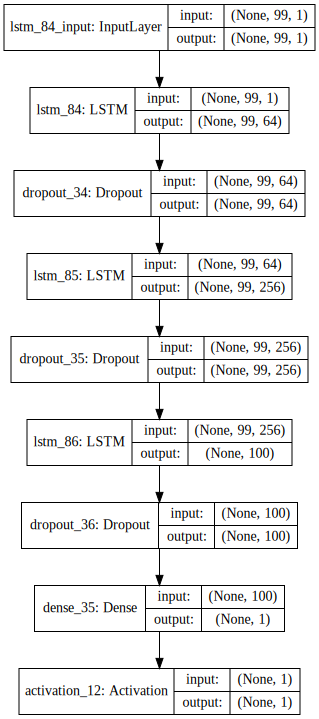

In [102]:
def build_model():
    model = Sequential()
    layers = {'input': 1, 'hidden1': 64, 'hidden2': 256, 'hidden3': 100, 'output': 1}

    model.add(LSTM(
            input_shape=(sequence_length - 1, layers['input']),
            units=layers['hidden1'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden2'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden3'],
            return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=layers['output']))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("Compilation Time : ", time.time() - start)
    return model

model_1 = build_model()
plot_model(model_1)

Compilation Time :  0.042111873626708984

Data Loaded.

Training...
Train on 2612 samples, validate on 138 samples
Epoch 1/1
2612/2612 [==============================] - 42s 16ms/step - loss: 0.1592 - val_loss: 0.0980
Predicting...
Reshaping predicted


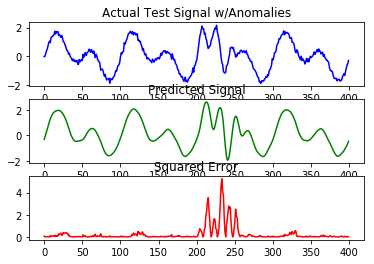

Training duration (s) :  51.18231773376465


In [136]:
model_1, y_test_1, predicted_1 = utils.run_network(
    model=build_model(), data=data, batch_size=batch_size, epochs=epochs)

### Improved model for sequence-to-sequence predection

### Encoder Decoder LSTM

Source: https://arxiv.org/pdf/1607.00148.pdf
-> RebuildInteresting: https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/

Compilation Time :  4.4843621253967285


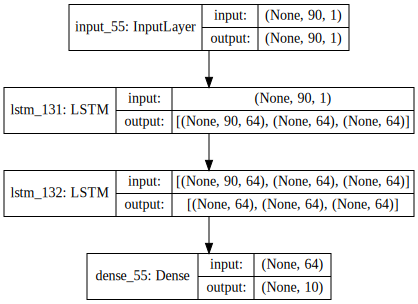

In [176]:
# X shape=(samples, timestamps, features)
# Y shape=(samples,)

# Hyperparameters
num_encoder_tokens = 1 # Only one feature present
num_output_tokens = 10 # Only predict one value # Update: equals prediction_amount
latent_dim = 64 # to avoid "kernel run out of time" situation. I used 256.

def build_enc_dec_model():
    # sequence_length - 1
    prediction_amount = 10
    encoder_inputs = Input(shape=(sequence_length - prediction_amount, num_encoder_tokens))
    
    encoder = LSTM(latent_dim,
                   batch_input_shape = (1, sequence_length - prediction_amount, num_encoder_tokens),
                   stateful = False,
                   return_sequences = True,
                   return_state = True,
                   recurrent_initializer = 'glorot_uniform')
    # state_h: "hidden state output for the last time step"
    # state_c: "cell state for the last input time step"
    encoder_outputs, state_h, state_c = encoder(encoder_inputs) # 'encoder_outputs' are ignored and only states are kept.
    encoder_states = [state_h, state_c]

    # Decoder training, using 'encoder_states' as initial state.
    # decoder_inputs = Input(shape=(None, num_encoder_tokens))

    decoder_lstm = LSTM(latent_dim,
                        batch_input_shape = (1, sequence_length - prediction_amount, num_encoder_tokens),
                        stateful = False,
                        return_sequences = False,
                        return_state = True,
                        dropout = 0.2,
                        recurrent_dropout = 0.2)

    # decoder_output: "hidden state for each input time step"
    decoder_outputs, _, _ = decoder_lstm(encoder_outputs, initial_state = encoder_states)
    # Suites only for reconstruction, not prediction (and not for negative values):
    # -> decoder_dense = TimeDistributed(Dense(num_output_tokens, activation = 'relu'))
    decoder_dense = Dense(num_output_tokens)
    decoder_outputs = decoder_dense(decoder_outputs)

    # training model
    training_model = Model([encoder_inputs], decoder_outputs)
    start = time.time()
    training_model.compile(optimizer = 'adam', loss = 'mse')
    print("Compilation Time : ", time.time() - start)
    return training_model

model_2 = build_enc_dec_model()
plot_model(model_2)

In [67]:
np.random.seed(1234)

# Global hyper-parameters
sequence_length = 100
epochs = 50
batch_size = 50

data = utils.get_split_prep_data(0, 700, 500, 1000, sequence_length)

wave1 1000
wave2 1000
wave3 50
Length of Data 1000
Creating train data...
Mean of train data :  0.0017174984265156412
Train data shape  :  (600, 100)
X shape: (600, 99)
y shape: (600,)
Creating test data...
Mean of test data :  0.01647475124693149
Test data shape  :  (400, 100)
Shape X_train (2750, 99)
Shape X_test (400, 99)


### Visualization


Data Loaded.

Training...
Train on 2496 samples, validate on 132 samples
Epoch 1/50
2496/2496 [==============================] - 7s 3ms/step - loss: 0.0217 - val_loss: 0.0134
Epoch 2/50
2496/2496 [==============================] - 7s 3ms/step - loss: 0.0200 - val_loss: 0.0171
Epoch 3/50
2496/2496 [==============================] - 7s 3ms/step - loss: 0.0183 - val_loss: 0.0140
Epoch 4/50
2496/2496 [==============================] - 7s 3ms/step - loss: 0.0171 - val_loss: 0.0149
Epoch 5/50
2496/2496 [==============================] - 7s 3ms/step - loss: 0.0172 - val_loss: 0.0134
Epoch 6/50
2496/2496 [==============================] - 7s 3ms/step - loss: 0.0162 - val_loss: 0.0140
Epoch 7/50
2496/2496 [==============================] - 7s 3ms/step - loss: 0.0155 - val_loss: 0.0140
Epoch 8/50
2496/2496 [==============================] - 7s 3ms/step - loss: 0.0157 - val_loss: 0.0143
Epoch 9/50
2496/2496 [==============================] - 7s 3ms/step - loss: 0.0153 - val_loss: 0.0135
Epoch 10

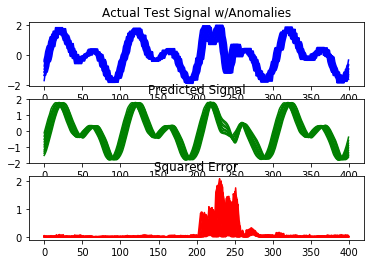

Training duration (s) :  360.68417859077454


In [299]:
model_2, y_test_2, predicted_2 = utils.run_network(model=model_2, data=data, batch_size=batch_size, epochs=epochs)

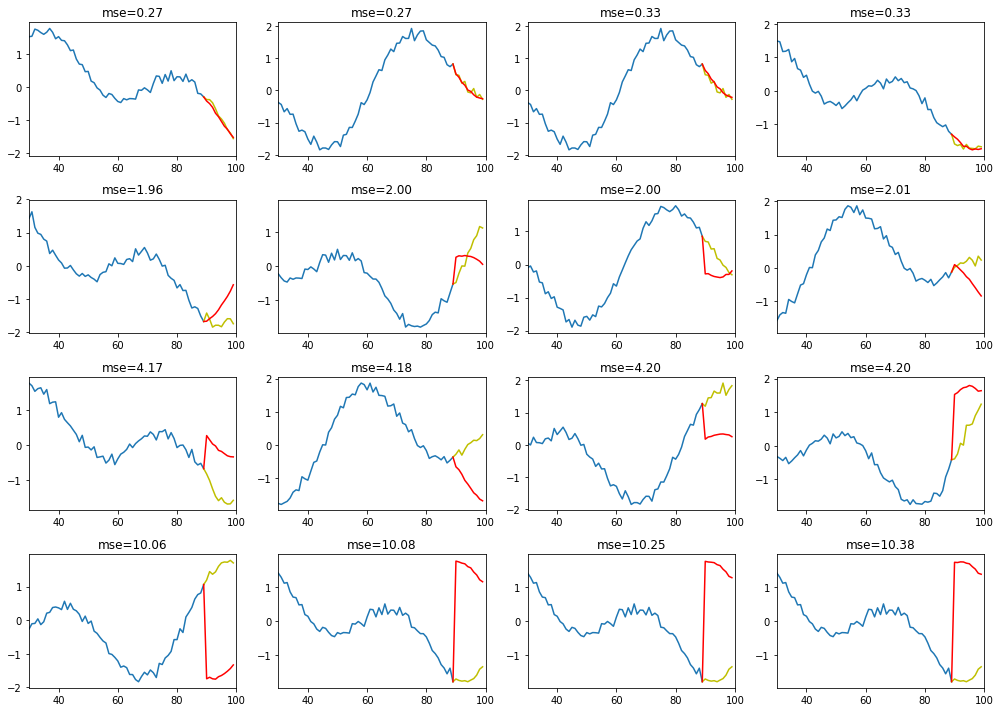

In [300]:
plot_samples(data, predicted_2)

### Inspect ECG data

(10000, 3)


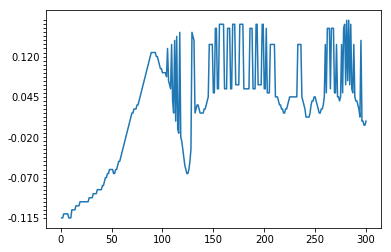

In [126]:
# Source: https://www.physionet.org/cgi-bin/atm/ATM
# Remove single quote from column names, remove first row (Einheiten)
ecg = pd.read_csv('data/ecg_p1_s1_samples.csv').rename(columns=lambda x: x[1:-1]).drop(0)
print(ecg.shape)
ecg.head()
fig, ax = plt.subplots()
ax.plot(ecg["ECG I filtered"][:300])
# plt.locator_params(axis='y', nbins=6)
every_nth = 10
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
# print(plt.yticks()[0])
# plt.yticks(np.linspace(int(plt.yticks()[0][0]), int(plt.yticks()[0][-1]), 10))